In [283]:
import os
import json
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [285]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Importing Dataset

In [286]:
data_dir = "features_ring"
dataframes = []

for file in os.listdir(data_dir):
    if file.endswith(".tsv"):
        df = pd.read_csv(os.path.join(data_dir, file), sep="\t", na_values=["", "-"])
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)
df['Interaction'] = df["Interaction"].fillna('Unclassified')

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968986 entries, 0 to 2968985
Data columns (total 32 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pdb_id        object 
 1   s_ch          object 
 2   s_resi        int64  
 3   s_ins         object 
 4   s_resn        object 
 5   s_ss8         object 
 6   s_rsa         float64
 7   s_phi         float64
 8   s_psi         float64
 9   s_a1          float64
 10  s_a2          float64
 11  s_a3          float64
 12  s_a4          float64
 13  s_a5          float64
 14  s_3di_state   float64
 15  s_3di_letter  object 
 16  t_ch          object 
 17  t_resi        int64  
 18  t_ins         object 
 19  t_resn        object 
 20  t_ss8         object 
 21  t_rsa         float64
 22  t_phi         float64
 23  t_psi         float64
 24  t_a1          float64
 25  t_a2          float64
 26  t_a3          float64
 27  t_a4          float64
 28  t_a5          float64
 29  t_3di_state   float64
 30  t_3di_letter  obje

### Training with full dataset

In [288]:
X = df.drop(columns=["pdb_id", "Interaction"])
y = df["Interaction"]

categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X[categorical_cols] = X[categorical_cols].fillna("missing")
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

In [289]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

In [290]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [292]:
from hgbc import build_model

model = build_model() 
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

mcc = matthews_corrcoef(y_val, y_pred)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

Train Accuracy: 0.4704
Validation Accuracy: 0.4697
Matthews Correlation Coefficient: 0.1990


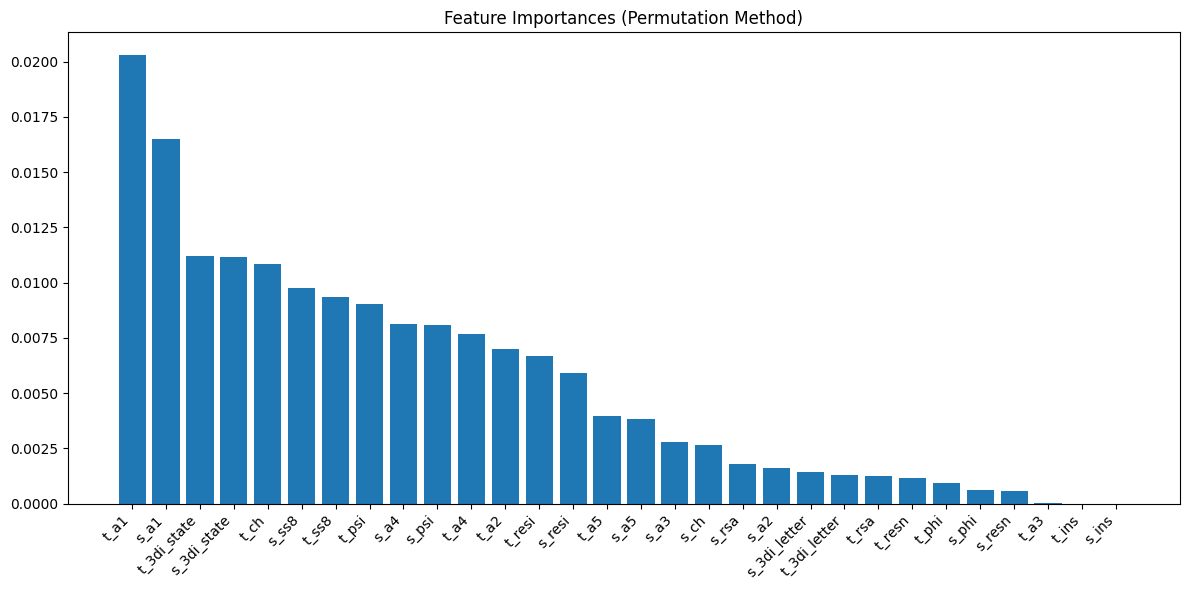

In [293]:
result = permutation_importance(
    model, X_val, y_val,
    n_repeats=10,
    random_state=SEED,
    scoring='accuracy'
)

importances = result.importances_mean
indices = np.argsort(importances)[::-1]
feature_names = X_val.columns[indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
plt.title("Feature Importances (Permutation Method)")
plt.tight_layout()
plt.show()

ROC AUC score: 0.7356


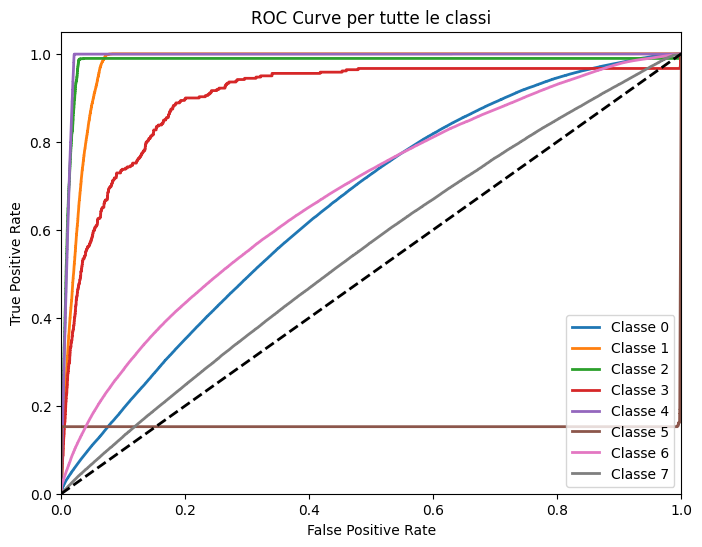

In [294]:
y_proba = model.predict_proba(X_val)

roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
print(f"ROC AUC score: {roc_auc:.4f}")

n_classes = y_proba.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    y_val_bin = (y_val == i)

    fpr, tpr, _ = roc_curve(y_val_bin, y_proba[:, i])

    plt.plot(fpr, tpr, lw=2, label=f'Classe {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per tutte le classi')
plt.legend(loc='lower right')
plt.show()

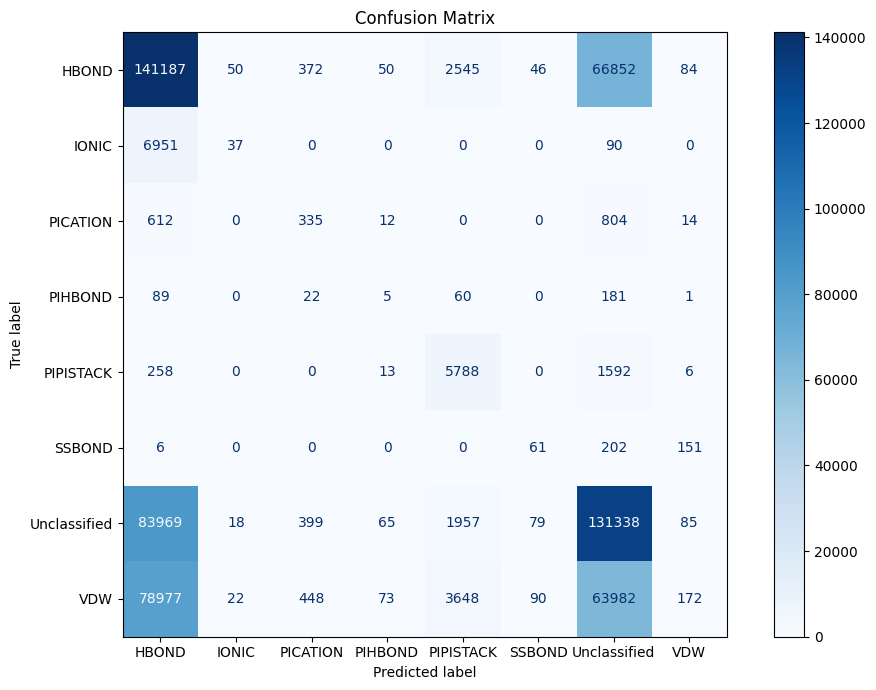

In [295]:
class_names = target_encoder.inverse_transform(model.classes_)

cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", ax=plt.gca())

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Preprocessing

In [296]:
data_dir = "features_ring"
dataframes = []

for file in os.listdir(data_dir):
    if file.endswith(".tsv"):
        df = pd.read_csv(os.path.join(data_dir, file), sep="\t", na_values=["", "-"])
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)
df['Interaction'] = df["Interaction"].fillna('Unclassified')

In [297]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
bad_interactions = ['HBOND', 'Unclassified', 'VDW']
nan_mask = df[numeric_cols].isna().any(axis=1)
interaction_mask = df['Interaction'].isin(bad_interactions)
drop_mask = nan_mask & interaction_mask
df = df[~drop_mask].copy()

print(f"Droppate {drop_mask.sum()} righe.")

Droppate 76078 righe.


In [298]:
for col in numeric_cols:
    df[col] = df.groupby("Interaction")[col].transform(lambda x: x.fillna(x.mean()))

In [299]:
X = df.drop(columns=["pdb_id", "Interaction"])
y = df["Interaction"]

categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X[categorical_cols] = X[categorical_cols].fillna("missing")

In [300]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

Data augmentation using SMOTE

In [301]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [302]:
inte = pd.DataFrame(y_train, columns=['Interaction'])
interaction_c = inte['Interaction'].value_counts()
print(interaction_c)
print(dict(enumerate(target_encoder.classes_)))

Interaction
6    849593
0    822020
7    573554
4     30626
1     28313
2      7108
5      1680
3      1432
Name: count, dtype: int64
{0: 'HBOND', 1: 'IONIC', 2: 'PICATION', 3: 'PIHBOND', 4: 'PIPISTACK', 5: 'SSBOND', 6: 'Unclassified', 7: 'VDW'}


In [303]:
strategy = {
    0: 822020,
    1: 28313,
    2: 40000,
    3: 40000, 
    4: 30626,  
    5: 40000,  
    6: 849593,
    7: 573554
}

smote = SMOTE(sampling_strategy=strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

/Users/filippobomben/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [304]:
inte = pd.DataFrame(y_resampled, columns=['Interaction'])
interaction_c = inte['Interaction'].value_counts()
print(interaction_c)

Interaction
6    849593
0    822020
7    573554
5     40000
2     40000
3     40000
4     30626
1     28313
Name: count, dtype: int64


In [309]:
from hgbc import build_model

model = build_model()
model.fit(X_resampled, y_resampled)

y_train_pred = model.predict(X_resampled)
train_acc = accuracy_score(y_resampled, y_train_pred)
print(f"Train Accuracy: {train_acc:.4f}")

y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
mcc = matthews_corrcoef(y_val, y_pred)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

Train Accuracy: 0.5231
Validation Accuracy: 0.5027
Matthews Correlation Coefficient: 0.2622


In [310]:
model_bundle = {
    "model": model,
    "features": X.columns.tolist()
}

joblib.dump(model_bundle, './data/model/hg_model.pkl')

['./data/model/hg_model.pkl']

In [311]:
feature_means = X_train.mean()
joblib.dump(feature_means, './data/model/feature_means.pkl')

['./data/model/feature_means.pkl']

In [312]:
training_columns = X_train.columns.tolist()
joblib.dump(training_columns, './data/model/training_features.pkl') 

['./data/model/training_features.pkl']

ROC AUC score: 0.8623


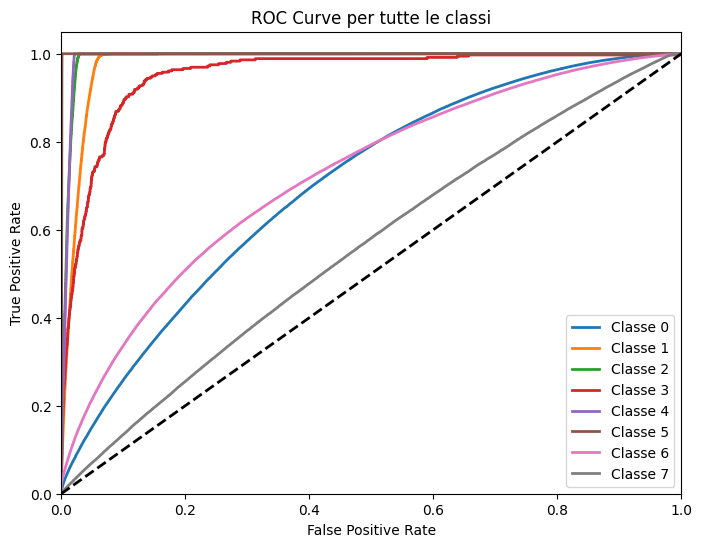

In [306]:
y_proba = model.predict_proba(X_val)

roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
print(f"ROC AUC score: {roc_auc:.4f}")

n_classes = y_proba.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    y_val_bin = (y_val == i)

    fpr, tpr, _ = roc_curve(y_val_bin, y_proba[:, i])

    plt.plot(fpr, tpr, lw=2, label=f'Classe {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per tutte le classi')
plt.legend(loc='lower right')
plt.show()

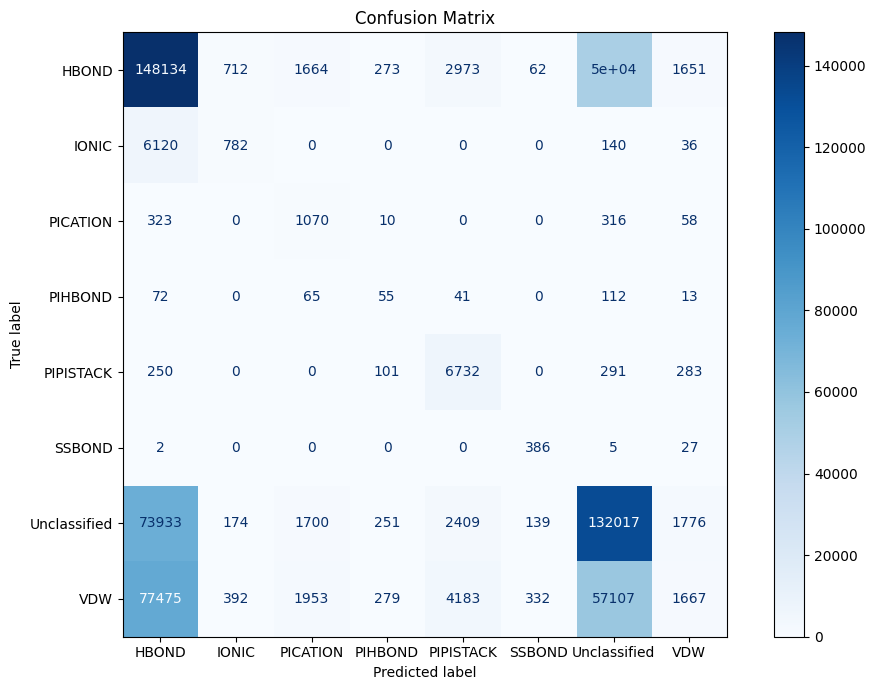

In [307]:
class_names = target_encoder.inverse_transform(model.classes_)

cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", ax=plt.gca())

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Using NN

In [273]:
from NN import Predictor
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

logger.info(f"Using device: {device}")

# Load config
CONFIG_PATH = "./data/script/configuration.json"
with open(CONFIG_PATH) as f:
    config = json.load(f)

# Hyperparameters
BATCH_SIZE = config.get("batch_size", 128)
EPOCHS = config.get("epochs", 20)
LEARNING_RATE = config.get("learning_rate", 1e-3)
DROPOUT = config.get("dropout_rate", 0.3)

print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}, Dropout: {DROPOUT}")


INFO:__main__:Using device: mps


Batch size: 64, Epochs: 30, Learning rate: 0.001, Dropout: 0.3


In [274]:
X_train_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_resampled), dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 7. Define model (you mentioned Predictor model, assumed defined elsewhere)
input_dim = X_train_tensor.shape[1]
output_dim = len(target_encoder.classes_)  # from your earlier LabelEncoder for y

model = Predictor(input_dim=input_dim, output_dim=output_dim, dropout=DROPOUT).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

INFO:__main__:Epoch 1/30 - Loss: 42638.1852 - Val Acc: 0.4584
INFO:__main__:Epoch 2/30 - Loss: 41642.7074 - Val Acc: 0.4608
INFO:__main__:Epoch 3/30 - Loss: 41369.8352 - Val Acc: 0.4712
INFO:__main__:Epoch 4/30 - Loss: 41252.3526 - Val Acc: 0.4751
INFO:__main__:Epoch 5/30 - Loss: 41140.1733 - Val Acc: 0.4740
INFO:__main__:Epoch 6/30 - Loss: 41076.5477 - Val Acc: 0.4670
INFO:__main__:Epoch 7/30 - Loss: 40833.8318 - Val Acc: 0.4782
INFO:__main__:Epoch 8/30 - Loss: 40669.8278 - Val Acc: 0.4801
INFO:__main__:Epoch 9/30 - Loss: 40597.8354 - Val Acc: 0.4806
INFO:__main__:Epoch 10/30 - Loss: 40559.1131 - Val Acc: 0.4795
INFO:__main__:Epoch 11/30 - Loss: 40530.9104 - Val Acc: 0.4806
INFO:__main__:Epoch 12/30 - Loss: 40475.0450 - Val Acc: 0.4792
INFO:__main__:Epoch 13/30 - Loss: 40362.6559 - Val Acc: 0.4818
INFO:__main__:Epoch 14/30 - Loss: 40329.1568 - Val Acc: 0.4803
INFO:__main__:Epoch 15/30 - Loss: 40308.1710 - Val Acc: 0.4842
INFO:__main__:Epoch 16/30 - Loss: 40282.0732 - Val Acc: 0.4837
I

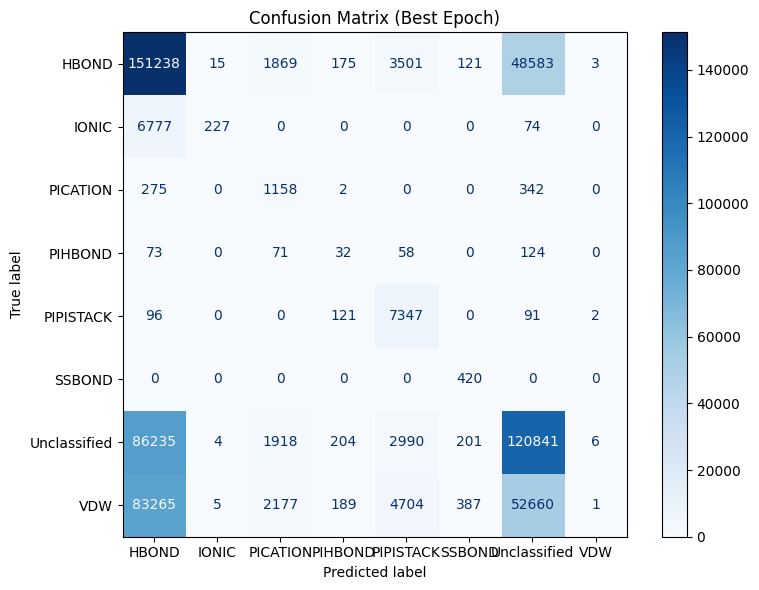

In [ ]:
best_val_acc = 0.0
best_model_state = None

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_acc = correct / total
    logger.info(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {total_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Salva il miglior modello
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

# Carica il miglior modello per la valutazione finale
model.load_state_dict(best_model_state)
model.eval()

# Calcola e mostra la confusion matrix
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, dim=1)

        y_true_all.extend(yb.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

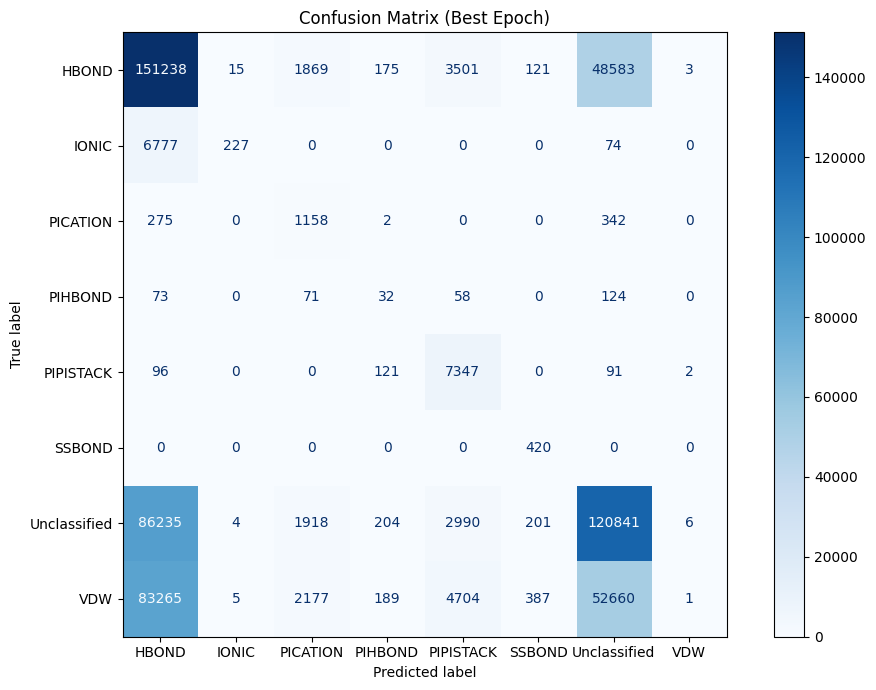

In [276]:
model.load_state_dict(best_model_state)
model.eval()

# Calcola e mostra la confusion matrix
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, dim=1)

        y_true_all.extend(yb.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=range(len(target_encoder.classes_)))

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
disp.plot(cmap="Blues", ax=plt.gca())

plt.title("Confusion Matrix (Best Epoch)")
plt.tight_layout()
plt.show()

In [ ]:
acc = accuracy_score(y_true_all, y_pred_all)


y_prob_all = []

with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)
        y_prob_all.append(probs.cpu().numpy())

y_prob_all = np.vstack(y_prob_all)

# ROC AUC multiclass (One-vs-Rest)
try:
    roc_auc = roc_auc_score(
        y_true_all, y_prob_all, multi_class='ovr', average='weighted'
    )
except ValueError:
    roc_auc = "ROC AUC not defined (perhaps due to missing classes)"

# Stampa le metriche
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
mcc = matthews_corrcoef(y_true_all, y_pred_all)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

Accuracy: 0.4861
ROC AUC: 0.6625
Matthews Correlation Coefficient: 0.2388


In [280]:
torch.save(model.state_dict(), "./data/model/model_weights.pth")

In [281]:
import joblib
joblib.dump(list(X.columns), "./data/model/features_nn.joblib")

['./data/model/features_nn.joblib']